In [2]:
# install new libraries
pip install costcla

**Remarks**

In this part, we will learn about credit scoring. Do you what credit scoring is? Credit scoring is to classify which potential customers are likely to default a contracted financial obligation based on the customer's past financial experience, and with that information decide whether to approve or decline a loan.

In [5]:
# load dataset and library
import pandas as pd
import numpy as np
from costcla.datasets import load_creditscoring1

# generate data
data = load_creditscoring1()
print(data.keys())

dict_keys(['data', 'target', 'cost_mat', 'target_names', 'DESCR', 'feature_names', 'name'])


In [7]:
# ingest data.data
feature = pd.DataFrame(data.data, columns = data.feature_names)
feature.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [8]:
# ingest data.target
target = pd.DataFrame(pd.Series(data.target).value_counts(), columns=('Frequency',))
target['%'] = target['Frequency'] / target['Frequency'].sum()
target.index = ['Negative (Good Customers', 'Positive (Bad Customers']
print(target)

                          Frequency         %
Negative (Good Customers     105299  0.932551
Positive (Bad Customers        7616  0.067449


In [20]:
# based on information above, we know imbalanced data
# we do some modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split

# splitting data
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = train_test_split(data.data, data.target, data.cost_mat)

# define modelling using training dataset
clf = {"RF" : {"f": RandomForestClassifier()},
       "DT" : {"f": DecisionTreeClassifier()},
      "LR" : {"f": LogisticRegression(max_iter = 350)},
       "XGB" : {"f": xgb.XGBClassifier(booster="gblinear")}}

# run fitting data
for model in clf.keys():
  # fit
  clf[model]["f"].fit(X_train, y_train)
  # predict result
  clf[model]["c"] = clf[model]["f"].predict(X_test)
  clf[model]["p"] = clf[model]["f"].predict_proba(X_test)
  clf[model]["p_train"] = clf[model]["f"].predict_proba(X_train)

In [21]:
# evaluate the model use metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
measures = {"f1": f1_score, "pre": precision_score,
            "rec": recall_score, "acc": accuracy_score}

result = pd.DataFrame(columns=measures.keys())

# evaluate each model
for model in clf.keys():
  result.loc[model] = [measures[measure](y_test, clf[model]["c"]) for measure in measures.keys()]

result

,f1,pre,rec,acc
RF,0.274432,0.548644,0.182979,0.935563
DT,0.254761,0.238095,0.273936,0.893266
LR,0.062655,0.480916,0.033511,0.933225
XGB,0.023983,0.605263,0.012234,0.933685


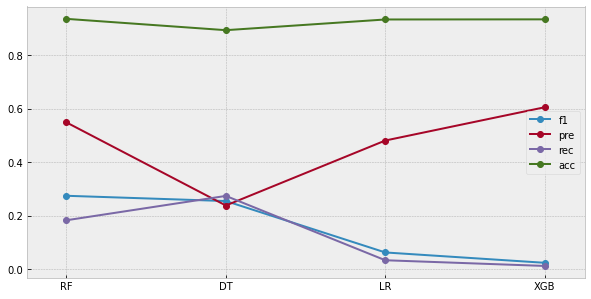

In [23]:
# plot the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("bmh")
from IPython.core.pylabtools import figsize

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(result.shape[0])
width = 0.2
l = ax.plot(ind, result, "-o")
plt.legend(iter(l), result.columns.tolist(), loc="center right", bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.25, ind[-1]+0.25])
ax.set_xticks(ind)
ax.set_xticklabels(result.index);

We got the evaluation of different models. Next steps, we can evaluate the model using standard cost-sensitive measures (It means costs of a correct classification). Let's check below:

In [24]:
# calculate of the savings of the models
# Dataset has already have cost matrix
# NOTED : cost_mat[C_FP, C_FN, C_TP, C_TN]
print(data.cost_mat[[10, 17, 50]])

[[ 1023.73054104 18750.             0.             0.        ]
 [  717.25781516  6749.25           0.             0.        ]
 [  866.65393177 12599.25           0.             0.        ]]


In [25]:
# calculate through by the model
from costcla.metrics import savings_score, cost_loss
# evaluate the savings for each model
result["sav"] = np.zeros(result.shape[0])
for model in clf.keys():
  result["sav"].loc[model] = savings_score(y_test, clf[model]["c"], cost_mat_test)

# show
result

,f1,pre,rec,acc,sav
RF,0.274432,0.548644,0.182979,0.935563,0.152293
DT,0.254761,0.238095,0.273936,0.893266,0.192730
LR,0.062655,0.480916,0.033511,0.933225,0.022439
XGB,0.023983,0.605263,0.012234,0.933685,0.004584


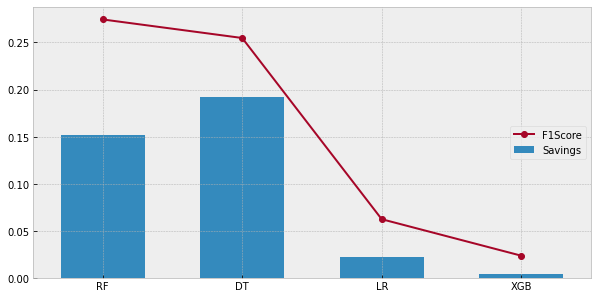

In [26]:
# plot dataset above

figsize(10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, result["f1"], "-o", label="F1Score", c="C1")
b = ax.bar(ind, result["sav"], 0.6, label="Savings")
plt.legend(loc="center right", bbox_to_anchor=(1, 0.5))

ax.set_xlim([-0.5, ind[-1]+0.5])
ax.set_xticks(ind)
ax.set_xticklabels(result.index);

There are significant differences in the results when evaluating a model using a traditional cost-insensitive measure such as the accuracy or F1Score, than when using the savings, leading to the conclusion of the importance of using the real practical financial costs of each context.

In [27]:
# Bayes Minimum Risk
from costcla.models import BayesMinimumRiskClassifier
ci_models = list(clf.keys())

for model in ci_models:
  clf[model+"-BMR"] = {"f": BayesMinimumRiskClassifier()}
  # fitting data
  clf[model+"-BMR"]["f"].fit(y_test, clf[model]["p"])
  # calibrating and predict
  clf[model+"-BMR"]["c"] = clf[model+"-BMR"]["f"].predict(clf[model]["p"], cost_mat_test)
  # evaluating model
  result.loc[model+"-BMR"] = 0
  result.loc[model+"-BMR", measures.keys()] = [measures[measure](y_test, clf[model+"-BMR"]["c"]) for measure in measures.keys()]
  result["sav"].loc[model+"-BMR"] = savings_score(y_test, clf[model+"-BMR"]["c"], cost_mat_test)

# show data
result

,f1,pre,rec,acc,sav
RF,0.274432,0.548644,0.182979,0.935563,0.152293
DT,0.254761,0.238095,0.273936,0.893266,0.192730
LR,0.062655,0.480916,0.033511,0.933225,0.022439
XGB,0.023983,0.605263,0.012234,0.933685,0.004584
RF-BMR,0.324878,0.213972,0.674468,0.813313,0.478396
DT-BMR,0.138042,0.082966,0.410638,0.658472,0.098625
LR-BMR,0.196260,0.122980,0.485638,0.735095,0.231348
XGB-BMR,0.160410,0.092800,0.590957,0.588012,0.163924


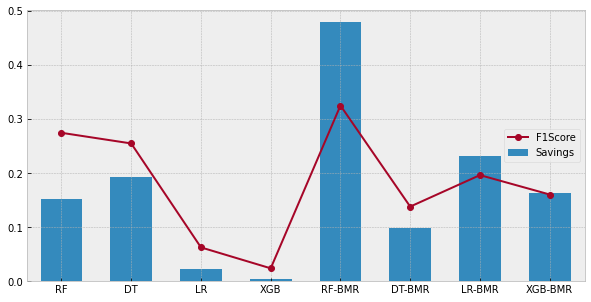

In [29]:
# plot dataset above

ind = np.arange(result.shape[0])
figsize(10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, result["f1"], "-o", label="F1Score", c="C1")
b = ax.bar(ind, result["sav"], 0.6, label="Savings")
plt.legend(loc="center right", bbox_to_anchor=(1, 0.5))

ax.set_xlim([-0.5, ind[-1]+0.5])
ax.set_xticks(ind)
ax.set_xticklabels(result.index);

In [31]:
# cost sensitive decision trees
from costcla.models import CostSensitiveDecisionTreeClassifier

clf["CSDT"] = {"f": CostSensitiveDecisionTreeClassifier()}
# Fitting data
clf["CSDT"]["f"].fit(X_train, y_train, cost_mat_train)
# Predicting data
clf["CSDT"]["c"] = clf["CSDT"]["f"].predict(X_test)
# Evaluating model
result.loc["CSDT"] = 0
result.loc["CSDT", measures.keys()] = \
[measures[measure](y_test, clf["CSDT"]["c"]) for measure in measures.keys()]
result["sav"].loc["CSDT"] = savings_score(y_test, clf["CSDT"]["c"], cost_mat_test)
    
result

,f1,pre,rec,acc,sav
RF,0.274432,0.548644,0.182979,0.935563,0.152293
DT,0.254761,0.238095,0.273936,0.893266,0.192730
LR,0.062655,0.480916,0.033511,0.933225,0.022439
XGB,0.023983,0.605263,0.012234,0.933685,0.004584
RF-BMR,0.324878,0.213972,0.674468,0.813313,0.478396
DT-BMR,0.138042,0.082966,0.410638,0.658472,0.098625
LR-BMR,0.196260,0.122980,0.485638,0.735095,0.231348
XGB-BMR,0.160410,0.092800,0.590957,0.588012,0.163924
CSDT,0.274834,0.165735,0.804255,0.717347,0.475814


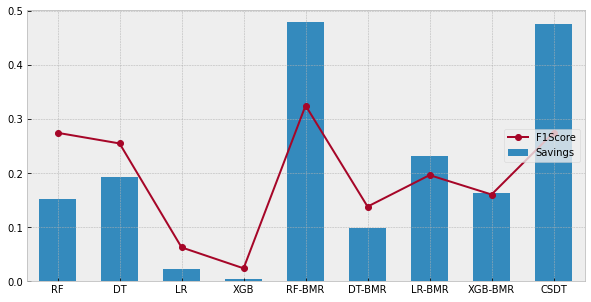

In [32]:
# plot dataset above

ind = np.arange(result.shape[0])
figsize(10, 5)
ax = plt.subplot(111)
l = ax.plot(ind, result["f1"], "-o", label="F1Score", c="C1")
b = ax.bar(ind, result["sav"], 0.6, label="Savings")
plt.legend(loc="center right", bbox_to_anchor=(1, 0.5))

ax.set_xlim([-0.5, ind[-1]+0.5])
ax.set_xticks(ind)
ax.set_xticklabels(result.index);

CostCla is a easy to use Python library for example-dependent cost-sensitive classification problems. It includes many example-dependent cost-sensitive algorithms. Since it is part of the scientific Python ecosystem, it can be easily integrated with other machine learning libraries.